### Solution for out of storage of your home directory.

a. Use this command to watch the storage usage of your home directory.
```du -ah --max-depth=1 | sort -hr```

b. You can remove the directory '.cache' in your home directory.
```rm -rf ~/.cache```

c. Also you can use softlink to redirect the large directory to 'hpc-share' directory.
for example, if you want to redirect the 'conda_envs' directory to 'hpc-share' directory, you can use the following command.
```ln -s /nfs/hpc/share/your_username/path/to/conda_envs conda_envs```
note that if the 'conda_envs' is already exist, you need to remove it or move it to other directory.

## 1. Introduction to Pytorch Profiler

It is a visual tool that helps you understand the performance of your Pytorch model.

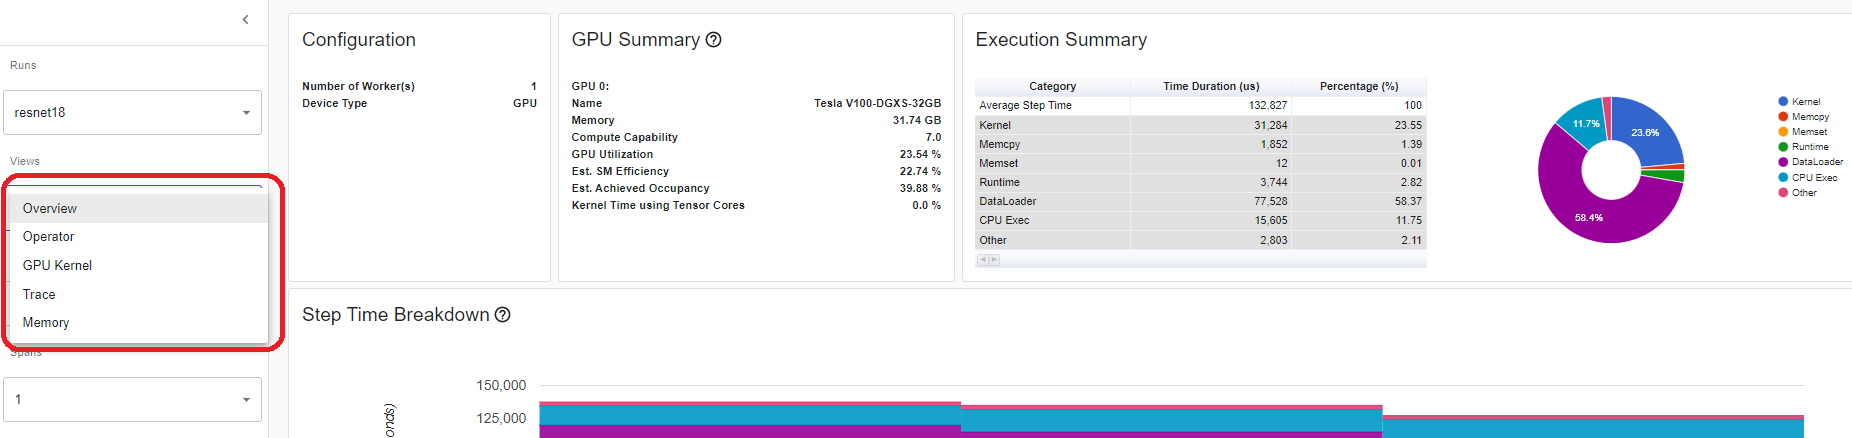

## 2. Installation

1. **Using a conda environment:**
      ```bash
      conda create -n cs599 python=3.10
      conda activate cs599
      ```

1. **Install PyTorch and torchvision:**
   ```bash
   pip install torch torchvision
   ```
   
2. **Install the TensorBoard plugin for PyTorch:**
   ```bash
   pip install torch_tb_profiler
   ```

3. **Install the jupyter notebook extension on the HPC for your VS Code.**

4. **Select the conda environment in VS Code:**

   Click the 'select kernel' button in the top right corner of the VS Code, and select the conda environment you created.


## 3. Prepare the data and model

In [ ]:
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T

### Prepare the input data.

In [7]:
transform = T.Compose(
    [T.Resize(224),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)

Files already downloaded and verified


### Create Resnet model, loss function, and optimizer objects. 

In [8]:
device = torch.device("cuda:0")
model = torchvision.models.resnet18(weights='IMAGENET1K_V1').cuda(device)
criterion = torch.nn.CrossEntropyLoss().cuda(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define the training step for each batch of input data.

In [2]:
def train(data):
    inputs, labels = data[0].to(device=device), data[1].to(device=device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 4. Profiling the model using Pytorch Profiler

In [9]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),  
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    for step, batch_data in enumerate(train_loader):
        prof.step()  # Need to call this at each step to notify profiler of steps' boundary.
        if step >= 1 + 1 + 3:
            break
        train(batch_data)

## 5. Run the profiler

Run the above code. The profiling result will be saved under ./log/resnet18 directory.

## 6. Use TensorBoard to visualize the profiling result

make sure you have installed the TensorBoard plugin for PyTorch using the command ```pip install torch_tb_profiler``` that you have done in section 2.

open the terminal in VS Code, and run the following command to start TensorBoard.

```tensorboard --logdir=./log/resnet18``` or ```tensorboard --logdir=./lab4/log/resnet18```

make sure you are using the right directory.

Then, you can open the TensorBoard in your browser by clicking the link in the terminal.

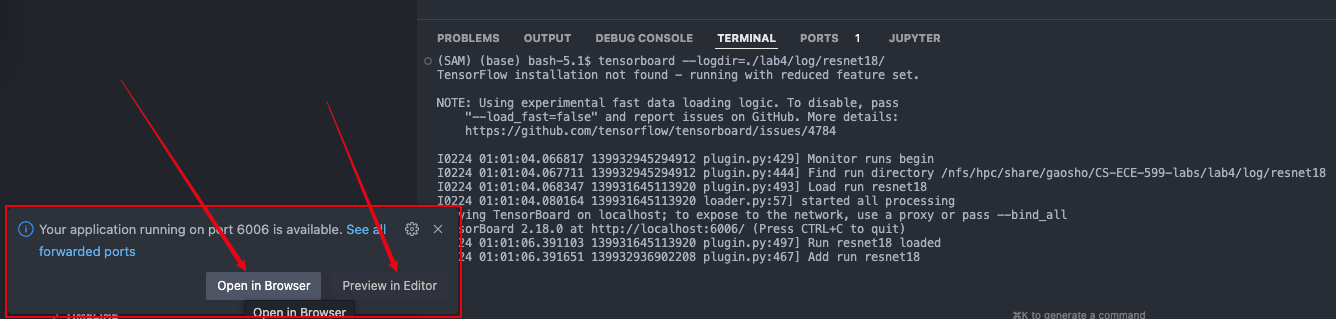

## 7. Improve performance of the model

- Increase the batch size.
- Increase the number of workers.

## 8. Task: Try another model and compare the performance.

Try to use another model, such as VGG16, and compare the performance with the resnet18.

You can use the following code to create the VGG16 model.
```python
model = torchvision.models.vgg16(weights='IMAGENET1K_V1').cuda(device)
```
